# Intro to acceleration methods

## Reminder about gradient descent

- Easy to implement
- It converges at least to stationary point
- Recent [paper](https://arxiv.org/pdf/1602.04915.pdf) shows that GD converges to a local minimizer **almost sure** with random initialization
- Linear convergence in strongly convex case
- $O(1/k)$ convergence in convex $L$-smooth case
- It strongly depends on the condition number of $f''(x)$, random initial guess vector can help

## Can we do better?

- Heavy-ball method
- Nesterov accelerated gradient method

## Heavy-ball method (Polyak, 1964)

$$
x_{k+1} = x_k - \alpha_k f'(x_k) + {\color{red}{\beta_k(x_k - x_{k-1})}}
$$

- Two-step non-monotone method
- Discretization of the ODE with friction term

$$
\ddot x + b \dot x + a f'(x) = 0
$$

- CG is special case of this form

### Heavy ball method visualization
Picture is from [this](https://www.princeton.edu/~yc5/ele538_optimization/lectures/accelerated_gradient.pdf) presentation
<img src="./heavy_ball.png" width=600 align="center">

### Convergence: $\mu$-strongly convex
- Rewrite method as 
\begin{equation*}
\begin{split} 
\begin{bmatrix} x_{k+1}\\ x_k \end{bmatrix}
 = \begin{bmatrix} (1 + \beta_k)I & -\beta_k I \\ I & 0 \end{bmatrix}
 \begin{bmatrix} x_k\\ x_{k-1} \end{bmatrix}
 +
 \begin{bmatrix} -\alpha_k f'(x_k)\\ 0 \end{bmatrix}
\end{split}
\end{equation*}
-  Use theorem from calculus
\begin{equation*}
\begin{split}
\begin{bmatrix} x_{k+1} - x^*\\ x_k - x^* \end{bmatrix}
 = 
 \underbrace{ \begin{bmatrix} (1 + \beta_k)I - \alpha_k \int_0^1 f''(x(\tau))d\tau & -\beta_k I\\ I & 0 \end{bmatrix}}_{=A_t}
 \begin{bmatrix} x_k - x^*\\ x_{k-1} - x^* \end{bmatrix},
\end{split}
\end{equation*}
where $x(\tau) = x_k + \tau(x^* - x_k) $
- Convergence depends on the spectrum of the iteration matrix $A_t$
- Select $\alpha_k$ and $\beta_k$ to make spectral radius the smallest 

### Theorem
Let $f$ be $L$-smooth and $\mu$-strongly convex. Then $\alpha_k = \frac{4}{(\sqrt{L} + \sqrt{\mu})^2}$ and $\beta_k = \max(|1 - \sqrt{\alpha_k L}|^2, |1 - \sqrt{\alpha_k \mu}|^2)$ gives

$$ 
\left\| \begin{bmatrix} x_{k+1} - x^* \\ x_k - x^* \end{bmatrix} \right\|_2
\leq 
\left( \frac{\sqrt{\kappa} - 1}{\sqrt{\kappa} + 1} \right)^k \left \|
\begin{bmatrix} x_1 - x^* \\ x_0 - x^* \end{bmatrix}
\right \|_2
$$


- Parameters depend on $L$ and $\mu$
- Faster than GD
- Similar to CG for $\mu$-strongly convex quadratic
- Can such estimate be extend to $L$-smooth convex function?

In [39]:
import liboptpy.base_optimizer as base
import numpy as np
import liboptpy.unconstr_solvers.fo as fo
import liboptpy.step_size as ss

class HeavyBall(base.LineSearchOptimizer):
    def __init__(self, f, grad, step_size, beta, **kwargs):
        super().__init__(f, grad, step_size, **kwargs)
        self._beta = beta
    
    def get_direction(self, x):
        self._current_grad = self._grad(x)
        return -self._current_grad

    def _f_update_x_next(self, x, alpha, h):
        if len(self.convergence) < 2:
            return x + alpha * h
        else:
            return x + alpha * h + self._beta * (x - self.convergence[-2])
    
    def get_stepsize(self):
        return self._step_size.get_stepsize(self._grad_mem[-1], self.convergence[-1], len(self.convergence))

## Quadratic experiments

In [58]:
n = 50
A = np.random.randn(n-1, n)
A = A.T.dot(A)
x_true = np.random.randn(n)
b = A.dot(x_true)
f = lambda x: 0.5 * x.dot(A.dot(x)) - b.dot(x)
grad = lambda x: A.dot(x) - b
A_eigvals = np.linalg.eigvalsh(A)
L = np.max(A_eigvals)
mu = np.min(A_eigvals)
print(L, mu, L / mu)
alpha_opt = 4 / (np.sqrt(L) + np.sqrt(mu))**2 
beta_opt = np.maximum((1 - np.sqrt(alpha_opt * L))**2, 
                      (1 - np.sqrt(alpha_opt * mu))**2)
print(alpha_opt, beta_opt)
# beta_opt = (np.sqrt(L) - np.sqrt(mu)) / (np.sqrt(L) + np.sqrt(mu))
# print((np.sqrt(L) - np.sqrt(mu)) / (np.sqrt(L) + np.sqrt(mu)))

207.51555614598283 -7.541612013625621e-15 -2.751607425190519e+16
nan nan


/Users/alex/anaconda3/envs/cvxpy/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':


In [62]:
methods = {
    "GD fixed": fo.GradientDescent(f, grad, ss.ConstantStepSize(1e-3)),
#     "GD Armijo": fo.GradientDescent(f, grad,
#             ss.Backtracking("Armijo", rho=0.5, beta=0.1, init_alpha=1.)),
    "HB": HeavyBall(f, grad, ss.ConstantStepSize(1e-3), beta=0.99),
#     "HB optimal": HeavyBall(f, grad, ss.ConstantStepSize(alpha_opt), beta = beta_opt)
}
x0 = np.random.randn(n)
max_iter = 60000
tol = 1e-7

In [63]:
for m in methods:
    _ = methods[m].solve(x0=x0, max_iter=max_iter, tol=tol)

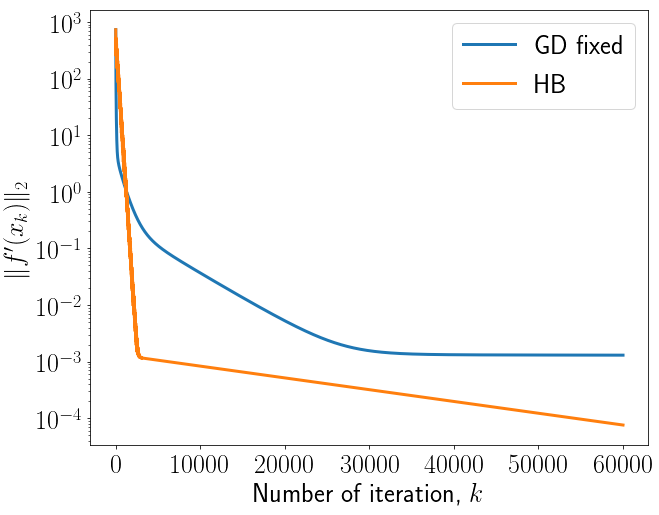

In [64]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc("text", usetex=True)

figsize = (10, 8)
fontsize = 26
plt.figure(figsize=figsize)
for m in methods:
    plt.semilogy([np.linalg.norm(grad(x)) for x in methods[m].get_convergence()], label=m, linewidth=3)
plt.legend(fontsize=fontsize)
plt.xlabel("Number of iteration, $k$", fontsize=fontsize)
plt.ylabel(r"$\| f'(x_k)\|_2$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)

### Heavy-ball method highlights

- Simple two-step method
- Converges much faster than GD with appropriate $\alpha_k$, $\beta_k$
- CG is particular case
- Proof only for $\mu$-strongly convex functions

## Nesterov accelerated methods (Nesterov, 1983)

One of possible notation variant

\begin{equation*}
\begin{split}
& y_0 = x_0 \\
& x_{k+1} = y_k - \alpha_k f'(y_k)\\
& y_{k+1} = x_{k+1} + \frac{k}{k + 3} (x_{k+1} - x_k)
\end{split}
\end{equation*}

- Heavy-ball comparison
- ODE interpretation again
- Non-monotone, too
- For those who likes geometry there exists [geometric descent](https://arxiv.org/pdf/1506.08187.pdf) with the same optimal speed of convergence 

### Nesterov method visualization

<img src="nesterov_plot.png" width=600>

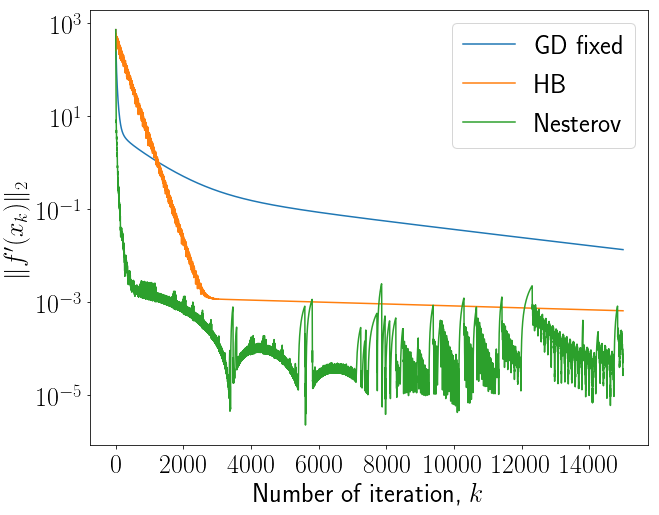

In [76]:
methods["Nesterov"] = fo.AcceleratedGD(f, grad, 
                                       ss.Backtracking("Lipschitz",
                                                       init_alpha=1.,
                                                       rho=0.3))
methods["Nesterov"].solve(x0=x0, max_iter=max_iter, tol=tol)
plt.figure(figsize=figsize)
for m in methods:
    plt.semilogy([np.linalg.norm(grad(x)) for x in 
                  methods[m].get_convergence()[:15000]], label=m)
plt.legend(fontsize=fontsize, loc="best")
plt.xlabel("Number of iteration, $k$", fontsize=fontsize)
plt.ylabel(r"$\| f'(x_k)\|_2$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)

## Nesterov accelerated method hightlights

- Optimal w.r.t. theoretical bounds
- Non-monotone, but [restarts](https://statweb.stanford.edu/~candes/papers/adap_restart_paper.pdf) can be useful
- Parameters tuning can be not so easy ($L$ and $\mu$ are unknown)
- Deep learning applications (see [Chapter 8 in Deep learning book](https://www.deeplearningbook.org/contents/optimization.html))
- Stochastic generalization

## Proximal methods

### Reminder of ODE interpretation of gradient descent

Consider the following ODE
$$
\frac{dx}{dt} = -f'(x(t))
$$
and after discretization

$$
\frac{x_{k+1} - x_k}{\alpha} = -f'(x_k),
$$

where $\alpha = t_{k+1} - t_k$ is a grid step and $x_k \equiv x(t_k)$

From this follows 

$$
x_{k+1} = x_k - \alpha f'(x_k),
$$

which is equivalent to gradient descent method

### Proximal method as backward Euler scheme

$$
\frac{dx}{dt} = -f'(x(t))
$$

and after discretization in backward manner

$$
\frac{x_{k+1} - x_k}{\alpha} = -f'({\color{red}{x_{k+1}}}),
$$

After some re-arrangements
\begin{align*}
& \left(\frac{1}{2\alpha} \|u - x_k\|_2^2 + f(u) \right)'(x_{k+1}) = 0 \\
& x_{k+1} = \arg\min_u \left(f(u) + \frac{1}{2\alpha} \|u - x_k\|_2^2\right) = prox_{\alpha f}(x_k)
\end{align*}



### Example: iterative refinement

The method to solve positive semi-definite linear system given Cholesky factorization of $A + \epsilon I$ for some $\epsilon$
$$
f(x) = \frac{1}{2}x^{\top}Ax - b^{\top}x \to \min_x,
$$
where $A \in \mathbb{S}^n_+$

\begin{align*}
prox_{\alpha f} (x_k) & = \arg\min_u \left(\frac{1}{2}u^{\top}Au - b^{\top}u + \frac{1}{2\alpha} \|u - x_k\|_2^2\right) \\
& = \left(A + (1/ \alpha) I\right)^{-1}\left(b + (1 / \alpha)x_k\right) \\
& = x_k + (A + \epsilon I)^{-1}(b - Ax_k)
\end{align*}

### Properties of proximal map 
$$
x_{k+1} = prox_{f}(x_k)
$$

a. Fixed point of proximal operator is equal to minimizer of $f$

$$
x^* = prox_f(x^*)
$$ 

Proximal map is not a contraction

There exists theory on firm non-expansiveness of proximal operator

Recent [paper](https://arxiv.org/pdf/1808.03971.pdf) proposes technique to deal with such kind of non-expansiveness

b. Resolvent of operator

$$
prox_{\alpha f}(x) = (I + \alpha f')^{-1}(x)
$$

This property can be extended to subdifferential.

### Modified gradient step interpretation

Assume $f$ is twice differentiable and strong convex ($f''(x) \succ 0$).

1. Gradient method as approximation of proximal method

$$
x_{k+1} = prox_{\alpha f} (x_k) = (I + \alpha f')^{-1}(x_k) \approx x_k - \alpha f'(x_k) + o(\alpha), \; \alpha \to 0  
$$

2. Proximal method for second-order approximation $\hat{f}(v) = f(x) + \langle f'(x), v - x \rangle + \frac{1}{2}\langle v - x, f''(x) (v - x) \rangle$

$$
prox_{\alpha \hat{f}}(x_k) = x_k - (f''(x_k) + (1 / \alpha)I)^{-1}f'(x_k) 
$$

### Separable sum

If $f$ has the form

$$
f(x) = \sum_{i=1}^n f_i(x_i)
$$

then 
$$
prox_f(v)_i = prox_{f_i}(v_i)
$$

- High parallelization of the proximal operator computing 
- **Consensus form** of the problem

$$
\min \sum_{i=1}^n f_i(x) \to \min \sum_{i=1}^n f_i(x_i), \; \text{s.t. } x_1 = \ldots = x_n
$$

- Well-stated for distributed optimization

## Proximal gradient method (PGM)

Consider convex function $f$ such that

$$
f(x) = h(x) + g(x),
$$

where $h(x)$ is convex differentiable, and $g(x)$ can be convex extended-value function, so $g: \mathbb{R}^n \to \mathbb{R} \cup \{+\infty\}$

Then the one step of the proximal gradient method is

$$
x_{k+1} = prox_{\alpha_k g} (x_k - \alpha_k h'(x_k))
$$

- Convergence rate $\mathcal{O}(1/k)$ for step size $\alpha_k \equiv \alpha \in (0, 1/L]$, where $L$ is Lipschitz constant of $f'$
- Backtracking procedure is available for adaptive search of $\alpha_k$

### Fixed point iteration interpretation

From the first-order optimality condition follows

\begin{align*}
& 0 \in \alpha h'(x^*) + \alpha\partial g(x^*)\\
& 0 \in \alpha h'(x^*) + x^* - x^* + \alpha\partial g(x^*)\\
& (I - \alpha h')(x^*) \in (I + \alpha \partial g)(x^*)\\
& x^* = (I + \alpha \partial g)^{-1}(I - \alpha h')(x^*)\\
& x^* = prox_{\alpha g}(x^* - \alpha h'(x^*))
\end{align*}

## Experiments

In [10]:
import numpy as np
def prox_alg(f, f_grad, g_prox, x0, num_iter, beta=0.5, fix_lam=None, accel=False):
    conv = [x0]
    x = x0.copy()
    if accel:
        t_prev = 1
        t_next = (1 + np.sqrt(1 + 4 * t_prev**2)) / 2.
    if fix_lam is None:
        lam = 1.
    for i in range(num_iter):
        if accel and i > 0:
            x = x + (t_prev - 1) / t_next * (x - conv[-2])
            t_prev = t_next
            t_next = (1 + np.sqrt(1 + 4 * t_prev**2)) / 2.
        if fix_lam is None:
            while True:
                z = g_prox(x - lam * f_grad(x), lam)
                if f(z) <= f(x) + f_grad(x).dot(z - x) + np.linalg.norm(z - x)**2 / (2 * lam):
                    break
                else:
                    lam = lam * beta
        else:
            z = g_prox(x - fix_lam * f_grad(x), fix_lam)
        x = z.copy()
        conv.append(x)
    return x, conv

In [3]:
f = lambda x: np.linalg.norm(A.dot(x) - y)**2 / 2
f_grad = lambda x: A.T.dot(A.dot(x) - y)
def g_prox(h, lam):
    return np.sign(h) * np.maximum(np.abs(h) - lam * gamma, 0) 

In [44]:
import sklearn.preprocessing as skprep
import numpy as np
m = 500
n = 2500
A = np.random.rand(m, n)
A = skprep.normalize(A, norm="l2", axis=0)
L = np.linalg.eigvalsh(A.T.dot(A)).max()
print(1./L)
x_true = np.random.randn(n)
x_true[np.random.rand(n) < 0.96] = 0
print("Number of nonzeros in x_true = {}".format(np.sum(x_true != 0)))
v = 9e-2 * np.random.randn(m)
y = A.dot(x_true) + v

0.000533053227275764
Number of nonzeros in x_true = 96


In [50]:
gamma = 0.1
num_iter = 2000
# x0 = np.zeros(n)
x0 = np.random.rand(n)

In [55]:
x, conv = prox_alg(f, f_grad, g_prox, x0, num_iter, fix_lam=1e-4)
print("Number nonzeros in x* = {}".format(np.sum(x != 0)))
print("f* = {}".format(f(x) + gamma * np.linalg.norm(x, 1)))
x_acc, conv_acc = prox_alg(f, f_grad, g_prox, x0, num_iter, 
                           fix_lam=1e-4, accel=True)
print("Number nonzeros in x* = {}".format(np.sum(x_acc != 0)))
print("f* = {}".format(f(x_acc) + gamma * np.linalg.norm(x_acc, 1)))
print(f(x_acc), f(x),
      np.linalg.norm(x_true - x), np.linalg.norm(x_true - x_acc))

Number nonzeros in x* = 2472
f* = 76.10922132097664
Number nonzeros in x* = 598
f* = 6.815583296905293
2.259832539992771 21.26858879331311 15.69079788939726 4.915421723827913


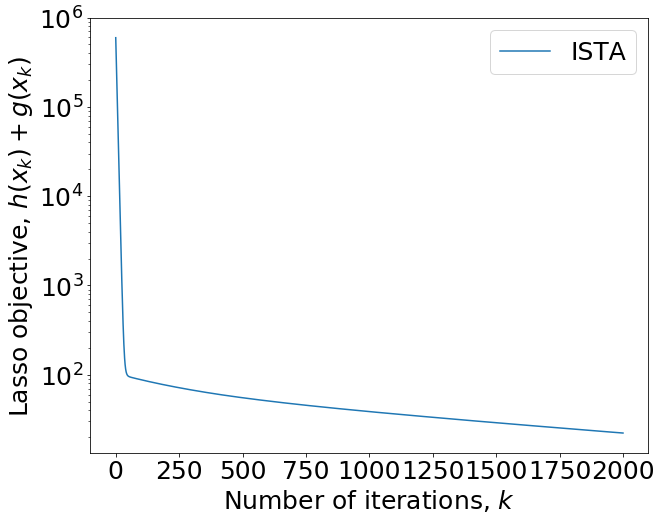

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10, 8))
fontsize=25
plt.plot([f(x) + gamma * np.linalg.norm(x, 1) for x in conv], label="ISTA")
# plt.plot([f(x) + gamma * np.linalg.norm(x, 1) for x in conv_acc], label="FISTA")
plt.legend(fontsize=fontsize)
plt.xlabel(r"Number of iterations, $k$", fontsize=fontsize)
plt.ylabel(r"Lasso objective, $h(x_k) + g(x_k)$", fontsize=fontsize)
plt.xticks(fontsize=fontsize)
_ = plt.yticks(fontsize=fontsize)
plt.yscale("log")

## Proximal algorithms highlights

- Very useful for composite objectives if one item is "simple"
- Many regularizers admit cheap prox evaluations
- Distributed optimization set up
- ADMM in later lectures...

## References

1. [Proximal algorithms](http://web.stanford.edu/~boyd/papers/pdf/prox_algs.pdf) and related [sources](http://web.stanford.edu/~boyd/papers/prox_algs.html) by N. Parikh and S. Boyd 
2. [Gradient-based algorithms with applications to signal recovery problems](http://www.math.tau.ac.il/~teboulle/papers/gradient_chapter.pdf) by A. Beck and M. Teboulle
3. [Proximal Backpropagation](https://arxiv.org/abs/1706.04638) by T Frerix et al (ICLR 2018)
4. [Stochastic Proximal Gradient Descent with Acceleration Techniques](https://papers.nips.cc/paper/5610-stochastic-proximal-gradient-descent-with-acceleration-techniques.pdf) by A. Nitanda (NIPS 2014)